In [1]:
import preprocessing
from config import TRENDS_DIR
%load_ext autoreload
%autoreload 2
import pandas as pd
import tqdm
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
from config import TWITTER_DATA_DIR
import pickle
import seaborn as sns
import statsmodels.formula.api as smf
import graphviz as gr
import warnings
from tqdm.notebook import tqdm
import numpy as np
from trending import build_df, get_trend_behavior
warnings.filterwarnings('ignore')
import trending

In [2]:
campaigns = preprocessing.load_campaign()

In [3]:
hashtag = 'jharkhandwithmodi'
tweets = campaigns[hashtag]

In [4]:
with open(os.path.join(TWITTER_DATA_DIR, 'exposure_results.pkl'), 'rb') as f:
    exposures = pickle.load(f)

## Combining All Hashtags and Normalizing Time

$Y_{iht} = \gamma_{h} + \lambda_t + \beta D_{ht} + \epsilon_{iht}$

In [76]:
dfs = []
for hashtag, tweet_dict in campaigns.items():
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        temp, _ = build_df(hashtag, tweet_dict, exposures, normalize_time=True, time_bin='5Min',
                          cutoff_choice='best', include_missing=False)
        temp = temp.assign(threshold=(temp.time > 0).astype(int))
        temp['hashtag'] = hashtag
        dfs.append(temp)
        
panel_df = pd.concat(dfs)

In [ ]:
panel_df

In [77]:
stata_df = panel_df.copy()
stata_df['hashtag'] = pd.Categorical(stata_df.hashtag).codes
stata_df.to_stata(os.path.join(TWITTER_DATA_DIR, 'optimal_panel.dta'))

## Plot All with Confidence Intervals

In [79]:
panel_df

,template,template_retweet,regular,regular_retweet,nonzero_exposure_regular,zero_exposure_regular,total_engagement,rt_engagement,hashtag,time,time_i,time_i2,trending_start,inferred_trending_start,threshold
adj_date,,,,,,,,,,,,,,,
-290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jharkhandwithmodi,-290,0,0,2019-02-17 15:30:00,0,0
-285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jharkhandwithmodi,-285,1,1,2019-02-17 15:30:00,0,0
-280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jharkhandwithmodi,-280,2,4,2019-02-17 15:30:00,0,0
-275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jharkhandwithmodi,-275,3,9,2019-02-17 15:30:00,0,0
-270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jharkhandwithmodi,-270,4,16,2019-02-17 15:30:00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,0.0,0.0,1.0,3.0,1.0,0.0,4.0,3.0,gappupappu,880,248,61504,2018-10-11 23:30:00,0,1
885,0.0,0.0,3.0,1.0,2.0,1.0,4.0,1.0,gappupappu,885,249,62001,2018-10-11 23:30:00,0,1
890,0.0,0.0,1.0,2.0,1.0,0.0,3.0,2.0,gappupappu,890,250,62500,2018-10-11 23:30:00,0,1


In [81]:
stata_check = panel_df.copy()
stata_check = stata_check.query('time >= -60 & time <= 60')
stata_check['new_time'] = stata_check.time + 60
stata_check.hashtag = pd.Categorical(stata_check.hashtag).codes
stata_check = stata_check.dropna()


In [91]:
stata_check.query('threshold == 1')

,template,template_retweet,regular,regular_retweet,nonzero_exposure_regular,zero_exposure_regular,total_engagement,rt_engagement,hashtag,time,time_i,time_i2,trending_start,inferred_trending_start,threshold,new_time
adj_date,,,,,,,,,,,,,,,,
5,38.0,1.0,15.0,2.0,3.0,12.0,56.0,3.0,23,5,59,3481,2019-02-17 15:30:00,0,1,65
10,46.0,0.0,18.0,3.0,8.0,10.0,67.0,3.0,23,10,60,3600,2019-02-17 15:30:00,0,1,70
15,107.0,21.0,13.0,26.0,13.0,0.0,167.0,47.0,23,15,61,3721,2019-02-17 15:30:00,0,1,75
20,128.0,9.0,16.0,7.0,14.0,2.0,160.0,16.0,23,20,62,3844,2019-02-17 15:30:00,0,1,80
25,90.0,65.0,10.0,25.0,9.0,1.0,190.0,90.0,23,25,63,3969,2019-02-17 15:30:00,0,1,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,17,40,80,6400,2018-10-11 23:30:00,0,1,100
45,0.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,17,45,81,6561,2018-10-11 23:30:00,0,1,105
50,0.0,1.0,0.0,3.0,0.0,0.0,4.0,4.0,17,50,82,6724,2018-10-11 23:30:00,0,1,110


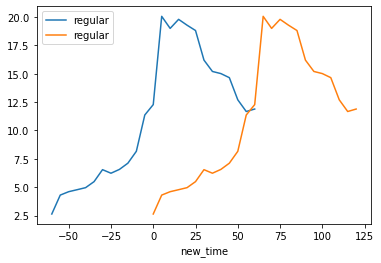

In [90]:
stata_check.groupby('time').regular.mean().plot()
stata_check.groupby('new_time').regular.mean().plot()
plt.legend()

In [107]:
time = list(range(-60,61,1))
dummy = [1 if t > 0 else 0 for t in time]
y = list(np.random.normal(0, 1, len(time)))
transformed_time = [t + 60 for t in time]

df = pd.DataFrame(zip(time, dummy, y, transformed_time),
                 columns=['Time', 'Treatment', 'Outcome', 'Time_plus_60'])



In [114]:
mod = smf.ols("Outcome ~ Treatment*Time", data=df).fit()
print(pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0].to_markdown())

ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.

In [112]:
mod = smf.ols("Outcome ~ Treatment*Time_plus_60", data=df).fit()
print(pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0].to_markdown())

                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.2206      0.252      0.875      0.383      -0.279       0.720
Treatment                  0.0213      0.729      0.029      0.977      -1.423       1.466
Time_plus_60              -0.0072      0.007     -0.997      0.321      -0.022       0.007
Treatment:Time_plus_60     0.0070      0.010      0.671      0.504      -0.014       0.028


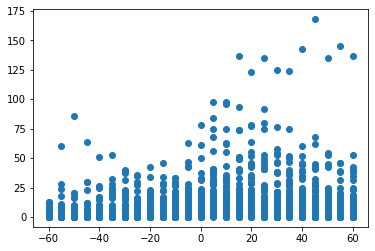

In [86]:
plt.scatter(stata_check.time, stata_check.regular)

In [85]:
mod = smf.ols("regular ~ time*threshold + nonzero_exposure_regular", data=stata_check).fit(cov_type='cluster', cov_kwds={'groups': query['hashtag']} )
temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.389100,0.232000,1.675000,0.094000,-0.066000,0.844000
time,-0.000100,0.009000,-0.015000,0.988000,-0.018000,0.018000
threshold,1.876800,0.366000,5.126000,0.000000,1.159000,2.594000
time:threshold,-0.035400,0.013000,-2.768000,0.006000,-0.060000,-0.010000
nonzero_exposure_regular,1.082700,0.010000,103.917000,0.000000,1.062000,1.103000


63


In [84]:
mod = smf.ols("regular ~ new_time*threshold + nonzero_exposure_regular", data=stata_check).fit(cov_type='cluster', cov_kwds={'groups': query['hashtag']} )
temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.397700,0.373000,1.065000,0.287000,-0.334000,1.129000
new_time,-0.000100,0.009000,-0.015000,0.988000,-0.018000,0.018000
threshold,4.000300,0.986000,4.056000,0.000000,2.067000,5.933000
new_time:threshold,-0.035400,0.013000,-2.768000,0.006000,-0.060000,-0.010000
nonzero_exposure_regular,1.082700,0.010000,103.917000,0.000000,1.062000,1.103000


63


In [ ]:
query = panel_df.query('time >= -60 & time <= 60').fillna(0)
# convert hashtags to numeric
query.hashtag = pd.Categorical(query.hashtag).codes
query = query.dropna()
mod = smf.ols("regular ~ time*threshold + nonzero_exposure_regular", data=query).fit(cov_type='cluster', cov_kwds={'groups': query['hashtag']} )
temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())

In [78]:
query = panel_df.query('time >= -60 & time <= 60').fillna(0)
# convert hashtags to numeric
query.hashtag = pd.Categorical(query.hashtag).codes
query = query.dropna()
mod = smf.ols("regular ~ time*threshold + nonzero_exposure_regular", data=query).fit(cov_type='cluster', cov_kwds={'groups': query['hashtag']} )
temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.389100,0.232000,1.675000,0.094000,-0.066000,0.844000
time,-0.000100,0.009000,-0.015000,0.988000,-0.018000,0.018000
threshold,1.876800,0.366000,5.126000,0.000000,1.159000,2.594000
time:threshold,-0.035400,0.013000,-2.768000,0.006000,-0.060000,-0.010000
nonzero_exposure_regular,1.082700,0.010000,103.917000,0.000000,1.062000,1.103000


63


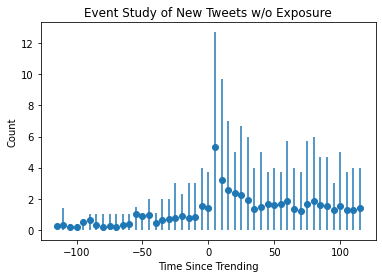

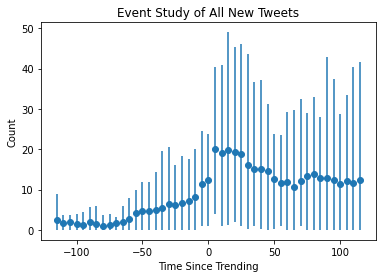

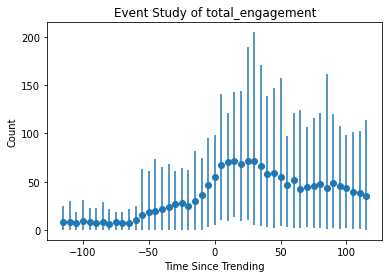

In [79]:
plot_event_study(panel_df, quantiles=(.1,.9), title='New Tweets w/o Exposure')
plt.show()
plot_event_study(panel_df, cat='regular', quantiles=(.1,.9), title='All New Tweets')
plt.show()
plot_event_study(panel_df, cat='total_engagement', quantiles=(.1,.9))

# More Modeling
Dean suggestions:
1. Run a random effects model to get a more general effect
2. Assume every possible trending time and average results 
3. Do more research and see what methods are out there

## Fixed Effect Model

In [80]:
query = panel_df.query('time >= -60 & time <= 60').fillna(0)
# convert hashtags to numeric
query.hashtag = pd.Categorical(query.hashtag).codes
query = query.dropna()
mod = smf.ols("regular ~ time*threshold + C(hashtag) + nonzero_exposure_regular", data=query).fit(cov_type='cluster', cov_kwds={'groups': query['hashtag']} )
temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.076400,0.223000,0.344000,0.731000,-0.360000,0.513000
time,0.000800,0.010000,0.079000,0.937000,-0.019000,0.021000
threshold,1.978100,0.374000,5.285000,0.000000,1.245000,2.712000
time:threshold,-0.037400,0.014000,-2.615000,0.009000,-0.065000,-0.009000
nonzero_exposure_regular,1.074200,0.014000,74.650000,0.000000,1.046000,1.102000


63


In [81]:
query = panel_df.query('time >= -60 & time <= 60').fillna(0)
# convert hashtags to numeric
query.hashtag = pd.Categorical(query.hashtag).codes
query = query.dropna()
mod = smf.ols("regular ~ time*threshold + nonzero_exposure_regular", data=query).fit(cov_type='cluster', cov_kwds={'groups': query['hashtag']} )
temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.389100,0.232000,1.675000,0.094000,-0.066000,0.844000
time,-0.000100,0.009000,-0.015000,0.988000,-0.018000,0.018000
threshold,1.876800,0.366000,5.126000,0.000000,1.159000,2.594000
time:threshold,-0.035400,0.013000,-2.768000,0.006000,-0.060000,-0.010000
nonzero_exposure_regular,1.082700,0.010000,103.917000,0.000000,1.062000,1.103000


63


### Including Quadratic Function

In [49]:
query = panel_df.query('time >= -60 & time <= 60').fillna(0)
# convert hashtags to numeric
query.hashtag = pd.Categorical(query.hashtag).codes
query = query.dropna()
mod = smf.ols("regular ~ time_i*threshold + threshold*time_i2 + C(hashtag) + nonzero_exposure_regular", data=query).fit(cov_type='cluster', cov_kwds={'groups': query['hashtag']} )
temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())
# ax = query.plot.scatter(x="time_i", y="regular", color="C0")
# query.assign(predictions=mod.fittedvalues).plot(x="time_i", y="predictions", ax=ax, color="C1")
# plt.title("Regression Discontinuity");


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,7.903800,1.956000,4.040000,0.000000,4.070000,11.738000
time_i,-0.193900,0.069000,-2.829000,0.005000,-0.328000,-0.060000
threshold,2.500400,0.790000,3.165000,0.002000,0.952000,4.049000
time_i:threshold,0.051200,0.072000,0.713000,0.476000,-0.090000,0.192000
time_i2,0.000900,0.001000,1.287000,0.198000,-0.000000,0.002000
threshold:time_i2,-0.000800,0.001000,-0.914000,0.361000,-0.002000,0.001000
nonzero_exposure_regular,1.137800,0.015000,74.089000,0.000000,1.108000,1.168000


63


## Random Effects
Interestingly enough, the fixed effects aren't doing anything"

In [82]:
mod = smf.mixedlm("regular ~ time*threshold + nonzero_exposure_regular", data=query, groups=query['hashtag']).fit()#cov_type='cluster', cov_kwds={'groups': query['hashtag']})
#temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
temp_df = mod.summary().tables[1].drop('Group Var')
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.423,0.206,2.047,0.041,0.018,0.827
time,0.000,0.005,0.086,0.932,-0.009,0.010
threshold,1.945,0.249,7.822,0.000,1.458,2.432
time:threshold,-0.037,0.007,-5.165,0.000,-0.051,-0.023
nonzero_exposure_regular,1.077,0.005,218.318,0.000,1.067,1.087


63


## Cumulative Stuff
Let's transform the df to be cumulative

In [15]:
df, _ = build_df(hashtag, tweets, exposures, normalize_time=True, time_bin='5Min', 
                 cutoff_choice='earliest', include_missing=False, cumulative=True)


In [18]:
dfs = []
for hashtag, tweet_dict in campaigns.items():
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        temp, _ = build_df(hashtag, tweet_dict, exposures, normalize_time=True, time_bin='5Min',
                          cutoff_choice='best', include_missing=False, cumulative=True)
        temp = temp.assign(threshold=(temp.time > 0).astype(int))
        temp['hashtag'] = hashtag
        dfs.append(temp)
        
panel_df = pd.concat(dfs)

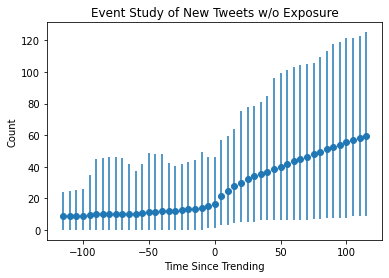

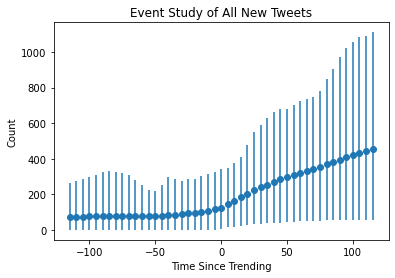

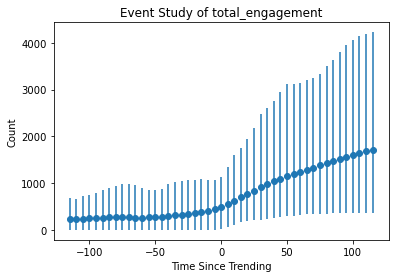

In [19]:
trending.plot_event_study(panel_df, quantiles=(.1,.9), title='New Tweets w/o Exposure')
plt.show()
trending.plot_event_study(panel_df, cat='regular', quantiles=(.1,.9), title='All New Tweets')
plt.show()
trending.plot_event_study(panel_df, cat='total_engagement', quantiles=(.1,.9))

In [21]:
query = panel_df.query('time >= -60 & time <= 60').fillna(0)
mod = smf.mixedlm("regular ~ time*threshold + nonzero_exposure_regular", data=query, groups=query['hashtag']).fit()#cov_type='cluster', cov_kwds={'groups': query['hashtag']})
#temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
temp_df = mod.summary().tables[1].drop('Group Var')
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,6.115,2.102,2.908,0.004,1.994,10.235
time,0.057,0.019,2.903,0.004,0.018,0.095
threshold,4.913,0.960,5.119,0.000,3.032,6.793
time:threshold,0.064,0.028,2.325,0.020,0.010,0.119
nonzero_exposure_regular,1.091,0.003,401.723,0.000,1.086,1.096


लक्ष्य_हमारा_मोदी_दोबारा


### Aside, use the stupid event study methodology

In [27]:
ht_df = panel_df.query(f'hashtag == "jharkhandwithmodi"')
estimation_period = ht_df.query('time >= -60 & time <= 0 ').fillna(0)
# regression is regular ~ nonzero_exposure_regular
mod = smf.ols('regular ~ nonzero_exposure_regular', data=estimation_period)
mod.fit()

## Choosing Random Start Times

In [28]:
import random

In [39]:
cached_dfs = [] 
for hashtag, tweet_dict in campaigns.items():
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        cached_dfs.append(
            trending.build_df(hashtag, tweet_dict, exposures, normalize_time=True, 
                              time_bin='5Min', cutoff_choice='best', cache=True)
        )


In [64]:
'{:.2e}'.format(12 ** 64)

'1.17e+69'

In [47]:
meta_res = []
for i in tqdm(range(1000)):
    dfs = []
    for new_df, temp, start in cached_dfs:
        chosen = False
        while not chosen:
            trend_time = random.choice(range(13))
            temp, _ = trending.build_df_cached(new_df.copy(), temp.copy(), start, normalize_time=True, 
                                               time_bin='5Min', cutoff_choice=trend_time)
            temp = temp.assign(threshold=(temp.time > 0).astype(int))
            temp['hashtag'] = hashtag
            temp['trend_time'] = trend_time
            dfs.append(temp)
            chosen=True
#             except Exception as e:
#                 print('failed for', hashtag, 'time', trend_time, 'with error', e)        

    panel_df = pd.concat(dfs)
    query = panel_df.query('time >= -60 & time <= 60').fillna(0)
    mod = smf.mixedlm("regular ~ time*threshold + nonzero_exposure_regular", data=query, groups=query['hashtag']).fit()#cov_type='cluster', cov_kwds={'groups': query['hashtag']})
    #temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
    temp_df = mod.summary().tables[1].drop('Group Var')
    temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
    #trending.highlight_reg_output(temp_df)
    #print(query.hashtag.max())
    meta_res.append(pd.concat({i: temp_df}, names=['trial']))

In [48]:
meta_df = pd.concat(meta_res)

In [59]:
meta_df['Trial'] = meta_df.index.get_level_values(0)
meta_df['Variable'] = meta_df.index.get_level_values(1)
meta_df = meta_df.astype({'Coef.': 'float', 'z': 'float'})


Text(0, 0.5, 'Model Parameter')

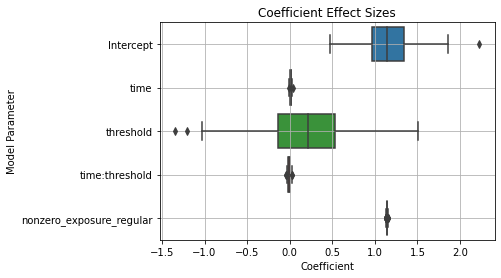

In [60]:
sns.boxplot(x='Coef.', y='Variable', data=meta_df, orient='h')
plt.grid(True)
plt.title('Coefficient Effect Sizes')
plt.xlabel('Coefficient')
plt.ylabel('Model Parameter')

(array([  2.,  18.,  66., 140., 186., 236., 192., 112.,  35.,  13.]),
 array([-3.53  , -2.7708, -2.0116, -1.2524, -0.4932,  0.266 ,  1.0252,
         1.7844,  2.5436,  3.3028,  4.062 ]),
 <BarContainer object of 10 artists>)

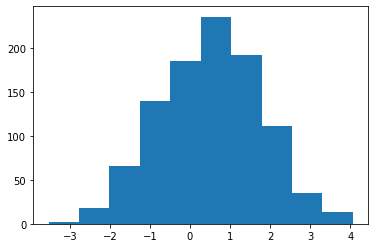

In [67]:
plt.hist(meta_df.query('Variable == "threshold"').z)

In [70]:
meta_df.groupby('Variable')['Coef.'].mean()

Variable
Intercept                   1.151678
nonzero_exposure_regular    1.144246
threshold                   0.193288
time                        0.012043
time:threshold             -0.007028
Name: Coef., dtype: float64

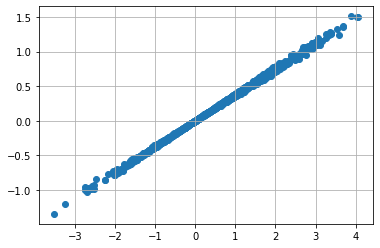

In [69]:
plt.scatter(x='z', y='Coef.', data=meta_df.query('Variable == "threshold"'))
plt.grid()

Text(0, 0.5, 'Model Parameter')

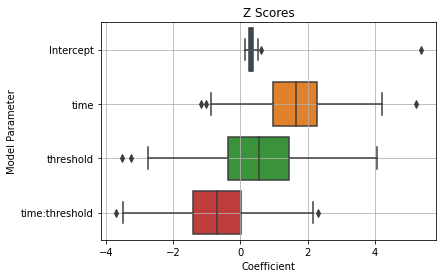

In [62]:
sns.boxplot(x='z', y='Variable', data=meta_df.query('Variable != "nonzero_exposure_regular"'), orient='h')
plt.grid(True)
plt.title('Z Scores')
plt.xlabel('Coefficient')
plt.ylabel('Model Parameter')

## Averaging Over All Possible Times
With 5 minute intervals, there are 12 possible trending times. There are 63 different models. There are thus 750 
different combinations. No it's 12^63. Too many.

I think this could work... I have a panel with all 12 possible series for each hashtag. 


In [71]:
dfs = []
for hashtag, tweet_dict in tqdm(campaigns.items()):
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        for trend_time in range(13):
            try:
                temp, _ = build_df(hashtag, tweet_dict, exposures, normalize_time=True, time_bin='5Min',
                          cutoff_choice=trend_time)
                temp = temp.assign(threshold=(temp.time > 0).astype(int))
                temp['hashtag'] = hashtag
                temp['trend_time'] = trend_time
                dfs.append(temp)
            except:
                print('failed for', hashtag, 'time', trend_time, 'with error', e)        
        
panel_df = pd.concat(dfs)

In [ ]:
panel_df.to_pickle(os.path.join(TWITTER_DATA_DIR, 'full_panel.pkl'))

In [75]:
stata_df = panel_df.copy()
stata_df['hashtag'] = pd.Categorical(stata_df.hashtag).codes
stata_df.to_stata(os.path.join(TWITTER_DATA_DIR, 'full_panel.dta'))

In [39]:
query = panel_df.query('time >= -60 & time <= 60').fillna(0)
# convert hashtags to numeric
query.hashtag = pd.Categorical(query.hashtag).codes
query = query.dropna()
mod = smf.ols("regular ~ time*threshold + nonzero_exposure_regular", data=query).fit(cov_type='cluster', cov_kwds={'groups': query['hashtag']})
temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,1.159400,0.235000,4.926000,0.000000,0.698000,1.621000
time,0.012200,0.005000,2.257000,0.024000,0.002000,0.023000
threshold,0.201700,0.108000,1.864000,0.062000,-0.010000,0.414000
time:threshold,-0.007700,0.008000,-0.966000,0.334000,-0.023000,0.008000
nonzero_exposure_regular,1.144200,0.015000,74.977000,0.000000,1.114000,1.174000


In [40]:
mod = smf.mixedlm("regular ~ time*threshold + nonzero_exposure_regular", data=query, groups=query['hashtag']).fit()#cov_type='cluster', cov_kwds={'groups': query['hashtag']})
#temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
temp_df = mod.summary().tables[1].drop('Group Var')
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,1.198,0.189,6.342,0.000,0.828,1.568
time,0.009,0.002,4.861,0.000,0.006,0.013
threshold,0.194,0.096,2.016,0.044,0.005,0.382
time:threshold,-0.005,0.003,-1.961,0.050,-0.011,-0.000
nonzero_exposure_regular,1.144,0.002,611.978,0.000,1.140,1.148


63


In [112]:
query = panel_df.query('time >= -60 & time <= 60').fillna(0)
# convert hashtags to numeric
query.hashtag = pd.Categorical(query.hashtag).codes
query = query.dropna()
mod = smf.ols("regular ~ time*threshold + nonzero_exposure_regular", data=query).fit(cov_type='cluster', cov_kwds={'groups': query['hashtag']})
temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,1.159400,0.235000,4.926000,0.000000,0.698000,1.621000
time,0.012200,0.005000,2.257000,0.024000,0.002000,0.023000
threshold,0.201700,0.108000,1.864000,0.062000,-0.010000,0.414000
time:threshold,-0.007700,0.008000,-0.966000,0.334000,-0.023000,0.008000
nonzero_exposure_regular,1.144200,0.015000,74.977000,0.000000,1.114000,1.174000


In [104]:
panel_df

,template,template_retweet,regular,regular_retweet,nonzero_exposure_regular,zero_exposure_regular,total_engagement,rt_engagement,hashtag,time,time_i,time_i2,trending_start,inferred_trending_start,threshold,trend_time
adj_date,,,,,,,,,,,,,,,,
-295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jharkhandwithmodi,-295,0,0,2019-02-17 15:30:00,0,0,0
-290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jharkhandwithmodi,-290,1,1,2019-02-17 15:30:00,0,0,0
-285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jharkhandwithmodi,-285,2,4,2019-02-17 15:30:00,0,0,0
-280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jharkhandwithmodi,-280,3,9,2019-02-17 15:30:00,0,0,0
-275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jharkhandwithmodi,-275,4,16,2019-02-17 15:30:00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0.0,0.0,1.0,6.0,1.0,0.0,7.0,6.0,gappupappu,885,248,61504,2018-10-11 23:30:00,0,1,12
890,0.0,0.0,4.0,3.0,3.0,1.0,7.0,3.0,gappupappu,890,249,62001,2018-10-11 23:30:00,0,1,12
895,0.0,0.0,1.0,2.0,1.0,0.0,3.0,2.0,gappupappu,895,250,62500,2018-10-11 23:30:00,0,1,12


In [86]:
meta_res = []
for hashtag, tweet_dict in campaigns.items():
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        for trend_time in range(13):
            try:
                res = trending.run_statistics(
                    *build_df(hashtag, tweet_dict, exposures,
                              time_bin='5Min', cutoff_choice=trend_time), 
                    periods=(12,12))
                meta_res.append(pd.concat({(hashtag, trend_time): res}, names=['Hashtag', 'trend_index']))
            except Exception as e:
                print('failed for', hashtag, 'time', trend_time, 'with error', e)

Not enough periods in df, running on model from  2019-02-09 17:00:00 to 2019-02-09 18:20:00
Not enough periods in df, running on model from  2019-02-09 17:00:00 to 2019-02-09 18:25:00
Not enough periods in df, running on model from  2019-02-09 17:00:00 to 2019-02-09 18:30:00
Not enough periods in df, running on model from  2019-02-09 17:00:00 to 2019-02-09 18:35:00
Not enough periods in df, running on model from  2019-02-09 17:00:00 to 2019-02-09 18:40:00
Not enough periods in df, running on model from  2019-02-09 17:00:00 to 2019-02-09 18:45:00
Not enough periods in df, running on model from  2019-02-09 17:00:00 to 2019-02-09 18:50:00
failed for timesofrahul time 0 with error index 0 is out of bounds for axis 0 with size 0
failed for timesofrahul time 1 with error index 0 is out of bounds for axis 0 with size 0
Not enough periods in df, running on model from  2019-04-22 08:35:00 to 2019-04-22 09:30:00
Not enough periods in df, running on model from  2019-04-22 08:35:00 to 2019-04-22 0

Not enough periods in df, running on model from  2019-04-19 15:40:00 to 2019-04-19 16:50:00
Not enough periods in df, running on model from  2019-04-19 15:40:00 to 2019-04-19 16:55:00
Not enough periods in df, running on model from  2019-04-19 15:40:00 to 2019-04-19 17:00:00
Not enough periods in df, running on model from  2019-04-19 15:40:00 to 2019-04-19 17:05:00
Not enough periods in df, running on model from  2019-04-19 15:40:00 to 2019-04-19 17:10:00
Not enough periods in df, running on model from  2019-04-19 15:40:00 to 2019-04-19 17:15:00
Not enough periods in df, running on model from  2019-04-19 15:40:00 to 2019-04-19 17:20:00
failed for indiabolemodidobara time 0 with error index 0 is out of bounds for axis 0 with size 0
failed for indiabolemodidobara time 1 with error index 0 is out of bounds for axis 0 with size 0
failed for indiabolemodidobara time 2 with error index 0 is out of bounds for axis 0 with size 0
failed for indiabolemodidobara time 3 with error index 0 is out o

Not enough periods in df, running on model from  2018-11-15 09:10:00 to 2018-11-15 10:35:00
Not enough periods in df, running on model from  2018-11-15 09:10:00 to 2018-11-15 10:40:00
Not enough periods in df, running on model from  2018-11-15 09:10:00 to 2018-11-15 10:45:00
Not enough periods in df, running on model from  2018-11-15 09:10:00 to 2018-11-15 10:50:00
Not enough periods in df, running on model from  2018-11-15 09:10:00 to 2018-11-15 10:55:00
Not enough periods in df, running on model from  2018-11-15 09:10:00 to 2018-11-15 11:00:00
Not enough periods in df, running on model from  2019-02-17 17:05:00 to 2019-02-17 18:20:00
Not enough periods in df, running on model from  2019-02-17 17:05:00 to 2019-02-17 18:25:00
Not enough periods in df, running on model from  2019-02-17 17:05:00 to 2019-02-17 18:30:00
Not enough periods in df, running on model from  2019-02-17 17:05:00 to 2019-02-17 18:35:00
Not enough periods in df, running on model from  2019-02-17 17:05:00 to 2019-02-

In [89]:
meta_df = pd.concat(meta_res)


In [95]:
import math

In [101]:
meta_df['inv_var'] = 1/((meta_df['std err']*math.sqrt(24))**2)
meta_df['coef*var'] = meta_df.coef * meta_df.inv_var

In [100]:
meta_df

coef  \
Hashtag           trend_index Trial                                          
jharkhandwithmodi 0           New Tweets Intercept                -22.6559   
                                         time_i                     0.4528   
                                         threshold                 51.7126   
                                         time_i:threshold          -0.8775   
                                         nonzero_exposure_regular   1.0380   
...                                                                    ...   
gappupappu        12          New Tweets Intercept                  5.4483   
                                         time_i                    -0.0580   
                                         threshold                 10.2778   
                                         time_i:threshold          -0.1326   
                                         nonzero_exposure_regular   0.8838   

                                                                   std err  \
Hashtag           trend_index Trial                                          
jharkhandwithmodi 0           New Tweets Intercept                  15.526   
                                         time_i                      0.306   
                                         threshold                  33.090   
                                         time_i:threshold            0.552   
                                         nonzero_exposure_regular    0.136   
...                                                                    ...   
gappupappu        12          New Tweets Intercept                   4.803   
                                         time_i                      0.074   
                                         threshold                   8.534   
                                         time_i:threshold            0.119   
                                         nonzero_exposure_regular    0.040   

                                                                        z  \
Hashtag           trend_index Trial                                         
jharkhandwithmodi 0           New Tweets Intercept                 -1.459   
                                         time_i                     1.482   
                                         threshold                  1.563   
                                         time_i:threshold          -1.590   
                                         nonzero_exposure_regular   7.627   
...                                                                   ...   
gappupappu        12          New Tweets Intercept                  1.134   
                                         time_i                    -0.780   
                                         threshold                  1.204   
                                         time_i:threshold          -1.111   
                                         nonzero_exposure_regular  22.327   

                                                                   P>|z|  \
Hashtag           trend_index Trial                                        
jharkhandwithmodi 0           New Tweets Intercept                 0.144   
                                         time_i                    0.138   
                                         threshold                 0.118   
                                         time_i:threshold          0.112   
                                         nonzero_exposure_regular  0.000   
...                                                                  ...   
gappupappu        12          New Tweets Intercept                 0.257   
                                         time_i                    0.435   
                                         threshold                 0.228   
                                         time_i:threshold          0.266   
                                         nonzero_exposure_regular  0.000   

                                                 

In [102]:
meta_df.reset_index().groupby(['level_3']).mean()

,trend_index,coef,std err,z,P>|z|,[0.025,0.975],var,inv_var,coef*var
level_3,,,,,,,,,,
Intercept,6.21066,-2.672001,5.266818,2.381547e+12,0.310671,-13.067312,7.578302,2459.527279,1.090633e+26,2.052679e+25
nonzero_exposure_regular,6.21066,1.119723,0.111057,1.569362e+13,0.000363,0.902047,1.337396,0.535593,3.397812e+27,3.397812e+27
threshold,6.21066,4.730780,14.088571,1.756244e-01,0.286274,-22.882310,32.343878,12180.082154,1.795757e+25,1.804576e+10
time_i,6.21066,0.057998,0.186726,1.378866e+11,0.299361,-0.308366,0.423581,3.096773,1.504762e+29,3.104067e+23
time_i:threshold,6.21066,-0.035307,0.335624,-1.276523e-01,0.268717,-0.693132,0.622528,7.503441,7.221820e+28,-1.668730e+12


### What happened with hashtags that didn't trend?

hooghly_chalo


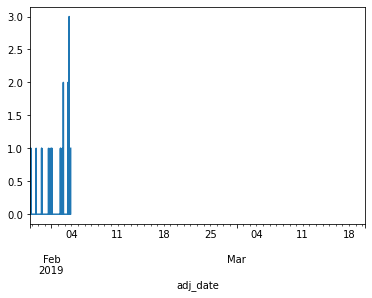

congressframedamitshah


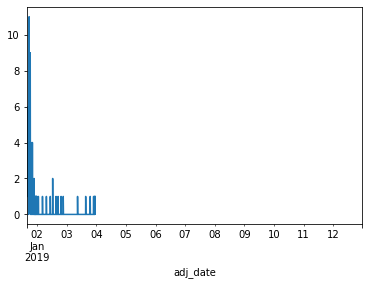

congressagainstnationalsecurity


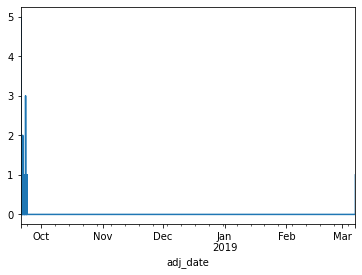

nris4modi


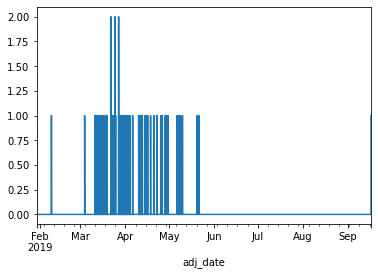

In [66]:
for hashtag, tweet_dict in campaigns.items():
    if hashtag in preprocessing.never_trended:
        print(hashtag)
        time_bin = '5Min'
        for t_id, tweet in tweet_dict.items():
            tweet['adj_date'] = tweet['date'] + timedelta(hours=5, minutes=30)
            if tweet['retweet_from'] == '':
                if tweet['template'] != '':
                    tweet['type'] = 'template'
                else:
                    tweet['type'] = 'regular'
            else:
                if tweet['template'] != '':
                    tweet['type'] = 'template_retweet'
                else:
                    tweet['type'] = 'regular_retweet'

            t_exp, n_exp, _ = exposures[hashtag][tweet['username']]
            tweet['template_exposure'] = t_exp
            tweet['normal_exposure'] = n_exp
            tweet['total_exposure'] = t_exp + n_exp

        df = pd.DataFrame.from_dict(tweet_dict).transpose()
        df.index = df['adj_date']
        colors = ["red","orange",'black','grey']
        types = ['template', 'template_retweet', 'regular', 'regular_retweet']

        series_list = []
        for t in types:
            temp = df[df.type == t] # only use regular tweets
            temp = temp.resample(time_bin).count().username
            series_list.append(temp)
        temp = df[df.type == 'regular'] # only use regular tweets
        series_list.append(temp[temp.total_exposure > 0].resample(time_bin).count().username)

        temp = temp[temp.total_exposure == 0].resample(time_bin).count().username
        series_list.append(temp)

        new_df = pd.DataFrame(series_list).T
        new_df.columns=[*types, 'nonzero_exposure_regular', 'zero_exposure_regular']
        new_df['total_engagement'] = new_df[types].sum(axis=1)
        new_df['rt_engagement'] = new_df[['regular_retweet', 'template_retweet']].sum(axis=1)
        new_df['hashtag'] = hashtag
        new_df['zero_exposure_regular'].plot()
        plt.show()


# Messing Around with Treatment Time

In [83]:
dfs = []
for hashtag, tweet_dict in campaigns.items():
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        temp, _ = build_df(hashtag, tweet_dict, exposures, normalize_time=True, time_bin='5Min',
                          cutoff_choice='earliest', include_missing=False)
        temp = temp.assign(threshold=(temp.time > 0).astype(int))
        temp['hashtag'] = hashtag
        dfs.append(temp)
        
panel_df = pd.concat(dfs)

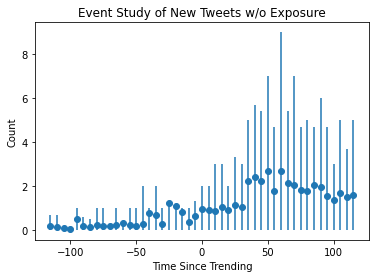

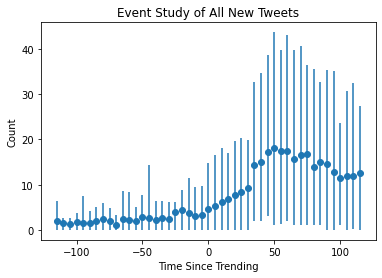

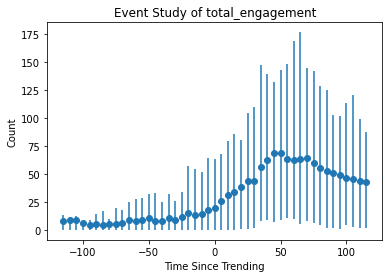

In [84]:
plot_event_study(panel_df, quantiles=(.1,.9), title='New Tweets w/o Exposure')
plt.show()
plot_event_study(panel_df, cat='regular', quantiles=(.1,.9), title='All New Tweets')
plt.show()
plot_event_study(panel_df, cat='total_engagement', quantiles=(.1,.9))

In [86]:
query = panel_df.query('time >= -60 & time <= 60').fillna(0)
query = query.dropna()
mod = smf.mixedlm("regular ~ time*threshold + nonzero_exposure_regular", data=query, groups=query['hashtag']).fit()#cov_type='cluster', cov_kwds={'groups': query['hashtag']})
temp_df = mod.summary().tables[1].drop('Group Var')
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.561,0.211,2.660,0.008,0.148,0.975
time,0.007,0.005,1.291,0.197,-0.004,0.018
threshold,-0.353,0.269,-1.312,0.190,-0.881,0.175
time:threshold,0.007,0.008,0.932,0.351,-0.008,0.022
nonzero_exposure_regular,1.095,0.006,181.137,0.000,1.083,1.107


लक्ष्य_हमारा_मोदी_दोबारा


In [92]:
query = panel_df.query('time >= -60 & time <= 120').fillna(0)
query = query.dropna()
mod = smf.mixedlm("regular ~ C(hashtag)*time*threshold + nonzero_exposure_regular", data=query, groups=query['hashtag']).fit()#cov_type='cluster', cov_kwds={'groups': query['hashtag']})
temp_df = mod.summary().tables[1].drop('Group Var')
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())


LinAlgError: Singular matrix

In [97]:
dfs = []
for hashtag, tweet_dict in campaigns.items():
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        temp, _ = build_df(hashtag, tweet_dict, exposures, normalize_time=True, time_bin='30Min',
                          cutoff_choice='best', include_missing=False)
        temp = temp.assign(threshold=(temp.time > 0).astype(int))
        temp['hashtag'] = hashtag
        dfs.append(temp)
        
panel_df = pd.concat(dfs)

In [98]:
query = panel_df.query('time >= -60 & time <= 120').fillna(0)
query = query.dropna()
mod = smf.mixedlm("regular ~ time*threshold + nonzero_exposure_regular", data=query, groups=query['hashtag']).fit()#cov_type='cluster', cov_kwds={'groups': query['hashtag']})
temp_df = mod.summary().tables[1].drop('Group Var')
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,2.024,1.032,1.962,0.050,0.002,4.046
time,0.014,0.026,0.548,0.584,-0.037,0.065
threshold,5.724,1.579,3.626,0.000,2.630,8.819
time:threshold,-0.063,0.030,-2.087,0.037,-0.122,-0.004
nonzero_exposure_regular,1.097,0.005,207.933,0.000,1.087,1.107


लक्ष्य_हमारा_मोदी_दोबारा


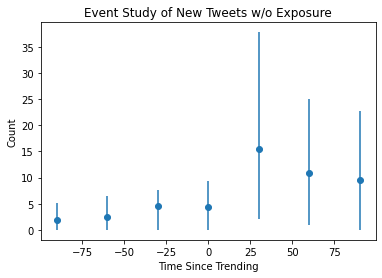

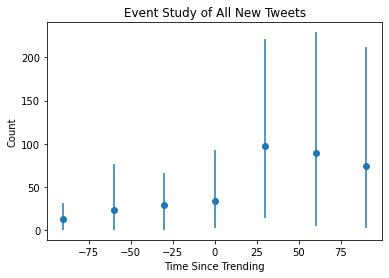

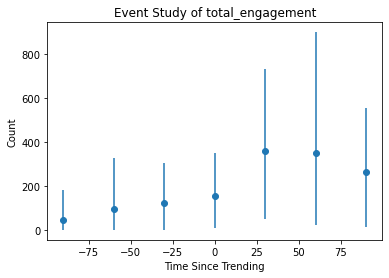

In [99]:
plot_event_study(panel_df, quantiles=(.1,.9), title='New Tweets w/o Exposure')
plt.show()
plot_event_study(panel_df, cat='regular', quantiles=(.1,.9), title='All New Tweets')
plt.show()
plot_event_study(panel_df, cat='total_engagement', quantiles=(.1,.9))

In [107]:
dfs = []
for hashtag, tweet_dict in campaigns.items():
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        temp, _ = build_df(hashtag, tweet_dict, exposures, normalize_time=True, time_bin='1H',
                          cutoff_choice='earliest', include_missing=False)
        temp = temp.assign(threshold=(temp.time > 0).astype(int))
        temp['hashtag'] = hashtag
        dfs.append(temp)
        
panel_df = pd.concat(dfs)

In [131]:
query = panel_df.query('time >= -60 & time <= 60').fillna(0)
query = query.dropna()
mod = smf.mixedlm("regular ~ time*threshold + nonzero_exposure_regular", data=query, groups=query['hashtag']).fit()#cov_type='cluster', cov_kwds={'groups': query['hashtag']})
temp_df = mod.summary().tables[1].drop('Group Var')
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.423,0.206,2.047,0.041,0.018,0.827
time,0.000,0.005,0.086,0.932,-0.009,0.010
threshold,1.945,0.249,7.822,0.000,1.458,2.432
time:threshold,-0.037,0.007,-5.165,0.000,-0.051,-0.023
nonzero_exposure_regular,1.077,0.005,218.318,0.000,1.067,1.087


लक्ष्य_हमारा_मोदी_दोबारा


In [110]:
query = panel_df.query('time >= -100 & time <= 120').fillna(0)
query = query.dropna()
mod = smf.mixedlm("regular ~ time*threshold + nonzero_exposure_regular", data=query, groups=query['hashtag']).fit()#cov_type='cluster', cov_kwds={'groups': query['hashtag']})
temp_df = mod.summary().tables[1].drop('Group Var')
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,1.939,3.112,0.623,0.533,-4.160,8.038
time,0.019,0.047,0.407,0.684,-0.073,0.111
threshold,-0.087,3.921,-0.022,0.982,-7.772,7.597
time:threshold,0.057,0.061,0.948,0.343,-0.061,0.176
nonzero_exposure_regular,1.102,0.007,159.479,0.000,1.089,1.116


लक्ष्य_हमारा_मोदी_दोबारा


In [104]:
panel_df

,template,template_retweet,regular,regular_retweet,nonzero_exposure_regular,zero_exposure_regular,total_engagement,rt_engagement,hashtag,time,time_i,time_i2,trending_start,inferred_trending_start,threshold
adj_date,,,,,,,,,,,,,,,
-330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jharkhandwithmodi,-330,0,0,2019-02-17 15:30:00,0,0
-270,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,jharkhandwithmodi,-270,1,1,2019-02-17 15:30:00,0,0
-210,6.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,jharkhandwithmodi,-210,2,4,2019-02-17 15:30:00,0,0
-150,9.0,0.0,1.0,0.0,0.0,1.0,10.0,0.0,jharkhandwithmodi,-150,3,9,2019-02-17 15:30:00,0,0
-90,785.0,158.0,97.0,78.0,66.0,31.0,1118.0,236.0,jharkhandwithmodi,-90,4,16,2019-02-17 15:30:00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,0.0,0.0,13.0,52.0,13.0,0.0,65.0,52.0,gappupappu,630,16,256,2018-10-11 23:30:00,0,1
690,0.0,0.0,18.0,36.0,16.0,2.0,54.0,36.0,gappupappu,690,17,289,2018-10-11 23:30:00,0,1
750,0.0,0.0,19.0,19.0,18.0,1.0,38.0,19.0,gappupappu,750,18,324,2018-10-11 23:30:00,0,1


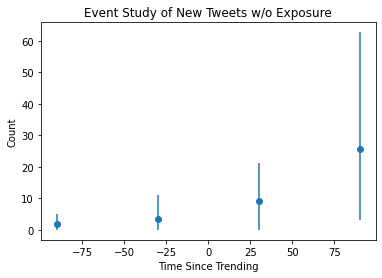

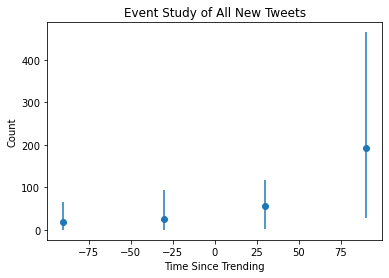

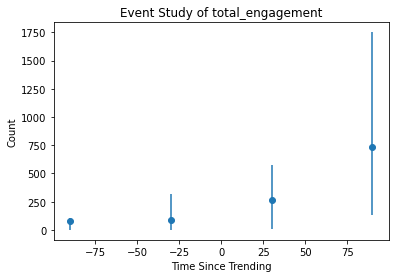

In [109]:
plot_event_study(panel_df, quantiles=(.1,.9), title='New Tweets w/o Exposure')
plt.show()
plot_event_study(panel_df, cat='regular', quantiles=(.1,.9), title='All New Tweets')
plt.show()
plot_event_study(panel_df, cat='total_engagement', quantiles=(.1,.9))

## Moving the Treatment

In [132]:
dfs = []
for hashtag, tweet_dict in campaigns.items():
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        temp, _ = build_df(hashtag, tweet_dict, exposures, normalize_time=True, time_bin='5Min',
                          cutoff_choice='best', include_missing=False, periods=6)
        temp = temp.assign(threshold=(temp.time > 0).astype(int))
        temp['hashtag'] = hashtag
        dfs.append(temp)
        
panel_df = pd.concat(dfs)

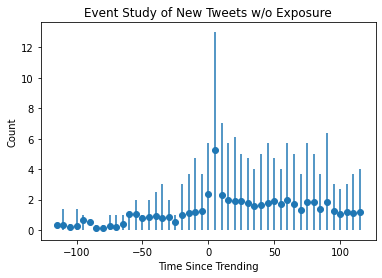

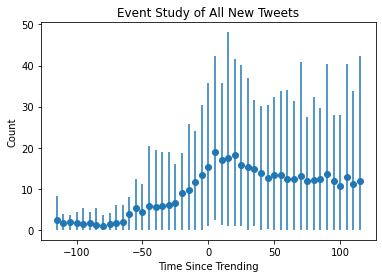

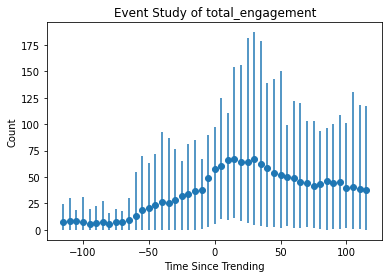

In [134]:
plot_event_study(panel_df, quantiles=(.1,.9), title='New Tweets w/o Exposure')
plt.show()
plot_event_study(panel_df, cat='regular', quantiles=(.1,.9), title='All New Tweets')
plt.show()
plot_event_study(panel_df, cat='total_engagement', quantiles=(.1,.9))

In [133]:
# biggest increase over 30 minutes
query = panel_df.query('time >= -60 & time <= 60').fillna(0)
query = query.dropna()
mod = smf.mixedlm("regular ~ time*threshold + nonzero_exposure_regular", data=query, groups=query['hashtag']).fit()#cov_type='cluster', cov_kwds={'groups': query['hashtag']})
temp_df = mod.summary().tables[1].drop('Group Var')
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.491,0.211,2.330,0.020,0.078,0.904
time,0.000,0.005,0.037,0.970,-0.010,0.010
threshold,1.349,0.246,5.484,0.000,0.867,1.831
time:threshold,-0.024,0.007,-3.333,0.001,-0.038,-0.010
nonzero_exposure_regular,1.081,0.005,224.210,0.000,1.072,1.091


लक्ष्य_हमारा_मोदी_दोबारा


In [135]:
dfs = []
for hashtag, tweet_dict in campaigns.items():
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        temp, _ = build_df(hashtag, tweet_dict, exposures, normalize_time=True, time_bin='5Min',
                          cutoff_choice='best', include_missing=False, periods=12)
        temp = temp.assign(threshold=(temp.time > 0).astype(int))
        temp['hashtag'] = hashtag
        dfs.append(temp)
        
panel_df = pd.concat(dfs)

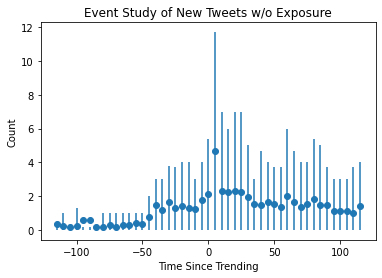

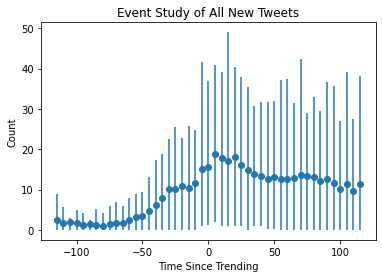

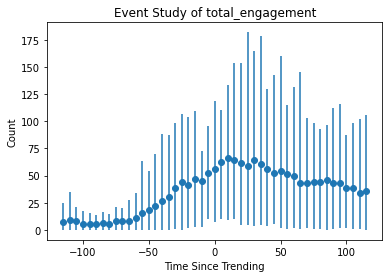

In [137]:
plot_event_study(panel_df, quantiles=(.1,.9), title='New Tweets w/o Exposure')
plt.show()
plot_event_study(panel_df, cat='regular', quantiles=(.1,.9), title='All New Tweets')
plt.show()
plot_event_study(panel_df, cat='total_engagement', quantiles=(.1,.9))

In [136]:
# biggest increase over 60 minutes
query = panel_df.query('time >= -60 & time <= 60').fillna(0)
query = query.dropna()
mod = smf.mixedlm("regular ~ time*threshold + nonzero_exposure_regular", data=query, groups=query['hashtag']).fit()#cov_type='cluster', cov_kwds={'groups': query['hashtag']})
temp_df = mod.summary().tables[1].drop('Group Var')
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.925,0.215,4.299,0.000,0.503,1.346
time,0.011,0.005,2.173,0.030,0.001,0.020
threshold,1.083,0.248,4.364,0.000,0.597,1.569
time:threshold,-0.038,0.007,-5.314,0.000,-0.052,-0.024
nonzero_exposure_regular,1.076,0.005,219.413,0.000,1.066,1.085


लक्ष्य_हमारा_मोदी_दोबारा


In [138]:
dfs = []
for hashtag, tweet_dict in campaigns.items():
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        temp, _ = build_df(hashtag, tweet_dict, exposures, normalize_time=True, time_bin='5Min',
                          cutoff_choice='best', include_missing=False, periods=4)
        temp = temp.assign(threshold=(temp.time > 0).astype(int))
        temp['hashtag'] = hashtag
        dfs.append(temp)
        
panel_df = pd.concat(dfs)

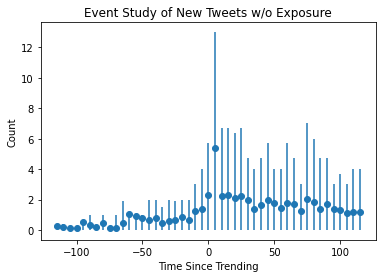

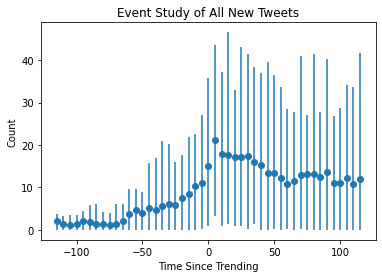

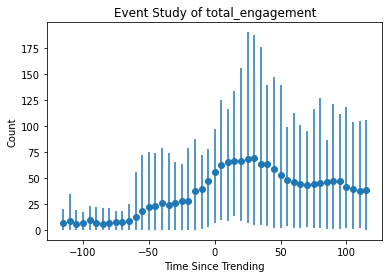

In [139]:
plot_event_study(panel_df, quantiles=(.1,.9), title='New Tweets w/o Exposure')
plt.show()
plot_event_study(panel_df, cat='regular', quantiles=(.1,.9), title='All New Tweets')
plt.show()
plot_event_study(panel_df, cat='total_engagement', quantiles=(.1,.9))

In [140]:
# biggest increase over 20 minutes
query = panel_df.query('time >= -60 & time <= 60').fillna(0)
query = query.dropna()
mod = smf.mixedlm("regular ~ time*threshold + nonzero_exposure_regular", data=query, groups=query['hashtag']).fit()#cov_type='cluster', cov_kwds={'groups': query['hashtag']})
temp_df = mod.summary().tables[1].drop('Group Var')
temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
trending.highlight_reg_output(temp_df)
print(query.hashtag.max())

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.553,0.205,2.694,0.007,0.151,0.956
time,0.004,0.005,0.703,0.482,-0.006,0.013
threshold,1.455,0.247,5.896,0.000,0.971,1.938
time:threshold,-0.032,0.007,-4.431,0.000,-0.046,-0.018
nonzero_exposure_regular,1.080,0.005,220.176,0.000,1.070,1.089


लक्ष्य_हमारा_मोदी_दोबारा


In [112]:
temp = panel_df

In [114]:
for cutoff in range(-30, 31, 5):
    temp = panel_df.assign(threshold=(panel_df.time >= cutoff).astype(int))
    x,y = -60 + cutoff, 60 + cutoff
    query = temp.query(f'time >= {x} & time <= {y}').fillna(0)
    query = query.dropna()
    mod = smf.mixedlm("regular ~ time*threshold + nonzero_exposure_regular", data=query, groups=query['hashtag']).fit()#cov_type='cluster', cov_kwds={'groups': query['hashtag']})
    temp_df = mod.summary().tables[1].drop('Group Var')
    temp_df = temp_df.loc[~temp_df.index.str.startswith('C', na=False)]
    print('cutoff shifted to :' , cutoff)
    trending.highlight_reg_output(temp_df)

cutoff shifted to : -30


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.418,0.406,1.031,0.303,-0.377,1.213
time,0.002,0.006,0.279,0.780,-0.010,0.014
threshold,0.480,0.398,1.205,0.228,-0.300,1.259
time:threshold,0.016,0.008,2.055,0.040,0.001,0.031
nonzero_exposure_regular,1.087,0.006,185.692,0.000,1.076,1.099


cutoff shifted to : -25


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.432,0.370,1.165,0.244,-0.295,1.158
time,0.002,0.006,0.404,0.686,-0.010,0.014
threshold,0.429,0.363,1.183,0.237,-0.282,1.140
time:threshold,0.005,0.008,0.608,0.543,-0.010,0.020
nonzero_exposure_regular,1.087,0.006,194.297,0.000,1.076,1.098


cutoff shifted to : -20


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.382,0.338,1.131,0.258,-0.280,1.045
time,0.002,0.006,0.291,0.771,-0.010,0.014
threshold,0.540,0.332,1.628,0.103,-0.110,1.191
time:threshold,-0.003,0.008,-0.381,0.703,-0.018,0.012
nonzero_exposure_regular,1.086,0.005,202.432,0.000,1.076,1.097


cutoff shifted to : -15


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.370,0.311,1.190,0.234,-0.239,0.978
time,0.001,0.006,0.153,0.878,-0.011,0.013
threshold,0.708,0.307,2.307,0.021,0.107,1.310
time:threshold,-0.008,0.007,-1.059,0.290,-0.023,0.007
nonzero_exposure_regular,1.082,0.005,210.005,0.000,1.072,1.092


cutoff shifted to : -10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.305,0.281,1.086,0.277,-0.246,0.856
time,-0.001,0.006,-0.118,0.906,-0.012,0.011
threshold,1.029,0.283,3.631,0.000,0.474,1.585
time:threshold,-0.014,0.007,-1.842,0.066,-0.028,0.001
nonzero_exposure_regular,1.079,0.005,213.900,0.000,1.069,1.089


cutoff shifted to : -5


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.205,0.255,0.801,0.423,-0.296,0.705
time,-0.004,0.006,-0.617,0.537,-0.015,0.008
threshold,1.380,0.267,5.166,0.000,0.856,1.903
time:threshold,-0.017,0.007,-2.381,0.017,-0.032,-0.003
nonzero_exposure_regular,1.081,0.005,215.934,0.000,1.071,1.091


cutoff shifted to : 0


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.348,0.232,1.498,0.134,-0.107,0.802
time,-0.001,0.006,-0.214,0.830,-0.012,0.010
threshold,1.482,0.253,5.846,0.000,0.985,1.979
time:threshold,-0.023,0.007,-3.169,0.002,-0.037,-0.009
nonzero_exposure_regular,1.079,0.005,218.349,0.000,1.070,1.089


cutoff shifted to : 5


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.400,0.209,1.918,0.055,-0.009,0.809
time,-0.001,0.005,-0.174,0.862,-0.012,0.010
threshold,1.875,0.246,7.620,0.000,1.393,2.357
time:threshold,-0.031,0.007,-4.375,0.000,-0.045,-0.017
nonzero_exposure_regular,1.077,0.005,219.482,0.000,1.067,1.086


cutoff shifted to : 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,1.437,0.187,7.680,0.000,1.070,1.804
time,0.033,0.005,6.188,0.000,0.022,0.043
threshold,-0.031,0.238,-0.130,0.897,-0.498,0.436
time:threshold,-0.046,0.007,-6.720,0.000,-0.060,-0.033
nonzero_exposure_regular,1.077,0.005,228.582,0.000,1.068,1.086


cutoff shifted to : 15


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,1.583,0.171,9.273,0.000,1.249,1.918
time,0.042,0.005,8.261,0.000,0.032,0.052
threshold,-0.511,0.234,-2.180,0.029,-0.970,-0.051
time:threshold,-0.048,0.007,-7.183,0.000,-0.061,-0.035
nonzero_exposure_regular,1.073,0.005,236.223,0.000,1.064,1.082


cutoff shifted to : 20


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,1.493,0.164,9.079,0.000,1.171,1.815
time,0.044,0.005,8.893,0.000,0.034,0.053
threshold,-0.571,0.236,-2.422,0.015,-1.032,-0.109
time:threshold,-0.045,0.006,-7.058,0.000,-0.058,-0.033
nonzero_exposure_regular,1.069,0.004,240.922,0.000,1.060,1.078


cutoff shifted to : 25


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,1.329,0.162,8.205,0.000,1.012,1.647
time,0.037,0.005,7.485,0.000,0.027,0.047
threshold,-0.551,0.253,-2.178,0.029,-1.046,-0.055
time:threshold,-0.036,0.006,-5.610,0.000,-0.049,-0.024
nonzero_exposure_regular,1.068,0.005,235.979,0.000,1.059,1.077


cutoff shifted to : 30


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,1.203,0.160,7.521,0.000,0.890,1.517
time,0.030,0.005,6.076,0.000,0.021,0.040
threshold,-0.558,0.272,-2.049,0.040,-1.092,-0.024
time:threshold,-0.028,0.007,-4.247,0.000,-0.040,-0.015
nonzero_exposure_regular,1.068,0.005,230.163,0.000,1.058,1.077


In [145]:
hashtag = 'jharkhandwithmodi'
tweets = campaigns[hashtag]
_ = build_df(hashtag, tweets, exposures, normalize_time=False, time_bin='5Min',
                          cutoff_choice='best', include_missing=False, periods=1)

In [149]:
list(tweets.values())[0]

{'username': 'bjp4latehar',
 'id': '1172033856607682560',
 'retweet_from': '',
 'template': '',
 'retweet_id': '',
 'text': 'आधारभूत संरचना हो या शिक्षा या फिर स्वच्छता या जल शक्ति अभियान, झारखण्ड के जिले लगातार सबसे ऊंचे पायदान पर अपनी उपस्थिति दर्ज करवा रहे हैं। #jharkhandwithmodi',
 'date': datetime.datetime(2019, 9, 12, 6, 27, 1),
 'retweets': 0,
 'favorites': 0,
 'adj_date': datetime.datetime(2019, 9, 12, 11, 57, 1),
 'type': 'regular',
 'template_exposure': 151,
 'normal_exposure': 64,
 'total_exposure': 215,
 'follower_data': True}

In [3]:
hashtag = 'jharkhandwithmodi'
tweets = campaigns[hashtag]

In [115]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge tabulate

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/jschless/.conda/envs/gt:

The following NEW packages will be INSTALLED:

    tabulate: 0.8.7-pyh9f0ad1d_0 conda-forge

tabulate-0.8.7 100% |################################| Time: 0:00:02  10.26 kB/s
